In [1]:
#%% Modules

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import torch as tc

from bptt.models import Model
import model_anafunctions as func
from tqdm import tqdm

from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

C:\Users\cestarellas\anaconda3\envs\PLAna\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#%% FUNCTIONS

def Avg_W_simulations(t_prev,t_post,xneu,Data_X,Data_Y,flag_state):
    # Function to simulate data from an average of W parameters across trials

    # Get parameters from the model
    _, W1t, W2t, _, _, Ct = m.get_latent_parameters()
    # Transform tensor to numpy format
    W2 = W2t.detach().numpy().transpose(1,2,0)
    W1 = W1t.detach().numpy().transpose(1,2,0)
    C = Ct.detach().numpy()

    # Computing W matrices for test trials
    W2_avg = tc.zeros((W2.shape[0],W2.shape[1]))
    W1_avg = tc.zeros((W1.shape[0],W1.shape[1]))
    W2_avg[:,:] = tc.from_numpy(W2[:,:,t_prev:t_post].mean(2)).float()
    W1_avg[:,:] = tc.from_numpy(W1[:,:,t_prev:t_post].mean(2)).float()

    W2_gen = [W2_avg for i in range(10)]
    W1_gen = [W1_avg for i in range(10)]

    #Generate Latent states
    ModelAvg = []
    #Generate Latent states
    data_X = tc.from_numpy(Data_X[t_prev][-2:-1,:]).float()
    ik=0
    for i in range(t_prev,t_post):
        input_trial=tc.from_numpy(Data_Y[i]).float()
        length_sim = input_trial.shape[0] 
        X, _ = m.generate_test_trajectory(data_X,W2_gen[ik],W1_gen[ik],input_trial,length_sim,i)
        ik+=1
        data_X = X[-2:-1,:]
        ModelAvg.append(X)
    Model_Average,_=func.concatenate_list(ModelAvg,0)

    Neuron_Average,_ = func.concatenate_list(Data_X[t_prev:t_post],0)

    # Reward and No Reward Trials
    Ext_input_average,_ = func.concatenate_list(Data_Y[t_prev:t_post],0)
    ini_trial = list(np.where(np.diff(Ext_input_average[:,0])==1.)[0]-49)
    end_trial = [ini_trial[i] for i in range(1,len(ini_trial))]+[Ext_input_average.shape[0]]

    Model_TAvg = [Model_Average[ini_trial[i]:end_trial[i],xneu] for i in range(len(ini_trial))]
    Neuron_TAvg = [Neuron_Average[ini_trial[i]:end_trial[i],xneu] for i in range(len(ini_trial))]
    Input_TAvg = [Ext_input_average[ini_trial[i]:end_trial[i],:] for i in range(len(ini_trial))]

    if flag_state==1:
        state = 4.0
        pos_ext_input=1
    else:
        state = 1.0
        pos_ext_input=2

    len_trials = np.min([i.shape[0] for i in Model_TAvg])
    RewardT = [i for i in range(len(ini_trial)) if np.sum(Input_TAvg[i][:,pos_ext_input]==state)>0]
    NoRewardT = [i for i in range(len(ini_trial)) if np.sum(Input_TAvg[i][:,pos_ext_input]==state)==0]

    M_Reward = np.zeros((len(RewardT),len_trials))
    N_Reward = np.zeros((len(RewardT),len_trials))

    for i,k in enumerate(RewardT):
        M_Reward[i,:]=Model_TAvg[k][:len_trials].reshape(1,-1)
        N_Reward[i,:]=Neuron_TAvg[k][:len_trials].reshape(1,-1)

    M_NOReward = np.zeros((len(NoRewardT),len_trials))
    N_NOReward = np.zeros((len(NoRewardT),len_trials))

    for i,k in enumerate(NoRewardT):
        M_NOReward[i,:]=Model_TAvg[k][:len_trials].reshape(1,-1)
        N_NOReward[i,:]=Neuron_TAvg[k][:len_trials].reshape(1,-1)

    return M_Reward,N_Reward,M_NOReward,N_NOReward

def Avg_W_sessions(t_prev,t_post,Data_X,Data_Y,flag_state,m):
    # Function to simulate data from an average of W parameters across trials

    # Get parameters from the model
    _, W1t, W2t, _, _, Ct = m.get_latent_parameters()
    # Transform tensor to numpy format
    W2 = W2t.detach().numpy().transpose(1,2,0)
    W1 = W1t.detach().numpy().transpose(1,2,0)
    C = Ct.detach().numpy()

    # Computing W matrices for test trials
    W2_avg = tc.zeros((W2.shape[0],W2.shape[1]))
    W1_avg = tc.zeros((W1.shape[0],W1.shape[1]))
    W2_avg[:,:] = tc.from_numpy(W2[:,:,t_prev:t_post].mean(2)).float()
    W1_avg[:,:] = tc.from_numpy(W1[:,:,t_prev:t_post].mean(2)).float()

    W2_gen = [W2_avg for i in range(10)]
    W1_gen = [W1_avg for i in range(10)]

    #Generate Latent states
    ModelAvg = []
    #Generate Latent states
    data_X = tc.from_numpy(Data_X[t_prev][-2:-1,:]).float()
    ik=0
    for i in range(t_prev,t_post):
        input_trial=tc.from_numpy(Data_Y[i]).float()
        length_sim = input_trial.shape[0] 
        X, _ = m.generate_test_trajectory(data_X,W2_gen[ik],W1_gen[ik],input_trial,length_sim,i)
        ik+=1
        data_X = X[-2:-1,:]
        ModelAvg.append(X)
    Model_Average,_=func.concatenate_list(ModelAvg,0)

    Neuron_Average,_ = func.concatenate_list(Data_X[t_prev:t_post],0)

    # Reward and No Reward Trials
    Ext_input_average,_ = func.concatenate_list(Data_Y[t_prev:t_post],0)
    ini_trial = list(np.where(np.diff(Ext_input_average[:,0])==1.)[0]-49)
    end_trial = [ini_trial[i] for i in range(1,len(ini_trial))]+[Ext_input_average.shape[0]]

    Model_TAvg = [Model_Average[ini_trial[i]:end_trial[i],:] for i in range(len(ini_trial))]
    Neuron_TAvg = [Neuron_Average[ini_trial[i]:end_trial[i],:] for i in range(len(ini_trial))]
    Input_TAvg = [Ext_input_average[ini_trial[i]:end_trial[i],:] for i in range(len(ini_trial))]

    if flag_state==1:
        state = 4.0
        pos_ext_input=1
    else:
        state = 1.0
        pos_ext_input=2

    len_trials = np.min([i.shape[0] for i in Model_TAvg])
    RewardT = [i for i in range(len(ini_trial)) if np.sum(Input_TAvg[i][:,pos_ext_input]==state)>0]
    NoRewardT = [i for i in range(len(ini_trial)) if np.sum(Input_TAvg[i][:,pos_ext_input]==state)==0]

    M_Reward_N = []
    N_Reward_N = []
    for ineu in range(Model_TAvg[0].shape[1]):
        M_Reward = np.zeros((len(RewardT),len_trials))
        N_Reward = np.zeros((len(RewardT),len_trials))
        for i,k in enumerate(RewardT):
            M_Reward[i,:]=Model_TAvg[k][:len_trials,ineu].reshape(1,-1)
            N_Reward[i,:]=Neuron_TAvg[k][:len_trials,ineu].reshape(1,-1)
        M_Reward_N.append(M_Reward)
        N_Reward_N.append(N_Reward)
        
    M_NOReward_N = []
    N_NOReward_N = []
    for ineu in range(Model_TAvg[0].shape[1]):
        M_NOReward = np.zeros((len(NoRewardT),len_trials))
        N_NOReward = np.zeros((len(NoRewardT),len_trials))
        for i,k in enumerate(NoRewardT):
            M_NOReward[i,:]=Model_TAvg[k][:len_trials,ineu].reshape(1,-1)
            N_NOReward[i,:]=Neuron_TAvg[k][:len_trials,ineu].reshape(1,-1)
        M_NOReward_N.append(M_NOReward)
        N_NOReward_N.append(N_NOReward)
        
    # Reward Real
    reward_real = []
    for ineu in range(Model_TAvg[0].shape[1]):
        corr_list=[]
        for i in range(N_Reward_N[ineu].shape[0]):
            corr_list.append(np.corrcoef(N_Reward_N[ineu].mean(0),N_Reward_N[ineu][i,:])[0,1])
        reward_real.append(np.array(corr_list).mean())
    
    # Reward Generated
    reward_generated = []
    for ineu in range(Model_TAvg[0].shape[1]):
        corr_list=[]
        for i in range(M_Reward_N[ineu].shape[0]):
            corr_list.append(np.corrcoef(M_Reward_N[ineu].mean(0),N_Reward_N[ineu][i,:])[0,1])
        reward_generated.append(np.array(corr_list).mean())
    
    # NO Reward Real
    noreward_real = []
    for ineu in range(Model_TAvg[0].shape[1]):
        corr_list=[]
        for i in range(N_NOReward_N[ineu].shape[0]):
            corr_list.append(np.corrcoef(N_NOReward_N[ineu].mean(0),N_NOReward_N[ineu][i,:])[0,1])
        noreward_real.append(np.array(corr_list).mean())
    
    # NO Reward Generated
    noreward_generated = []
    for ineu in range(Model_TAvg[0].shape[1]):
        corr_list=[]
        for i in range(M_NOReward_N[ineu].shape[0]):
            corr_list.append(np.corrcoef(M_NOReward_N[ineu].mean(0),N_NOReward_N[ineu][i,:])[0,1])
        noreward_generated.append(np.array(corr_list).mean())
    
    return reward_real,reward_generated,noreward_real,noreward_generated


def Hyper_mod(mpath,data_path):
    file=open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),'rb')
    hyper=pickle.load(file)
    file.close()
    hyper['data_path']=os.path.join(data_path,'Training_data.npy').replace('\\','/')
    hyper['inputs_path']=os.path.join(data_path,'Training_inputs.npy').replace('\\','/')
    full_name = open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),"wb")                      # Name for training data
    pickle.dump(hyper,full_name)            # Save train data
    #close save instance 
    full_name.close()

In [3]:
#%% Load Data and Behaviour
################################ Directories and files to modify ################################ 
# Select Path for multi-unit data
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets\\' 
#data_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/neuralactivity/OFC/CE17/L6/Test0/datasets/' 
# Select Path for Models (Folder containing the specific models to test)
model_path = 'D:\\_work_cestarellas\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\results'
#model_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/results/Tuning_OFC_CE17_221008'

# Loading models and simulations
model_name = 'DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400/001'
#model_name = 'CE1701_HU_256_l1_0.001_l2_08_l3_00_SL_400_encdim_65/001'

## Loading recorded neuronal activity (pre-processesed)

mpath=os.path.join(model_path,model_name).replace('\\','/')

train_n,train_i = func.load_data(data_path,'Training')
test_n,test_i = func.load_data(data_path,'Test')
NeuronPattern={"Training_Neuron":train_n,"Training_Input":train_i,
               "Testing_Neuron":test_n,"Testing_Input":test_i}
Hyper_mod(mpath,data_path)
# Loading Model
num_epochs = 150000
m = Model()
m.init_from_model_path(mpath, epoch=num_epochs)
m.eval()

# Simulating Training Data
ModelS=[]
for w_index in tqdm(range(len(NeuronPattern["Training_Neuron"]))):
    data_trial=tc.from_numpy(NeuronPattern["Training_Neuron"][w_index]).float()          # tensor of neuronal data for initial trial data
    input_trial = tc.from_numpy(NeuronPattern["Training_Input"][w_index]).float()
    length_sim = input_trial.shape[0]
    X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
    ModelS.append(X[:,:])
Model_Signal,_=func.concatenate_list(ModelS,0)                                             # Full session generated by the model 
Train_Signal,_=func.concatenate_list(train_n,0)                                            # Full session recorded and preprocessed             


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:05<00:00,  9.49it/s]


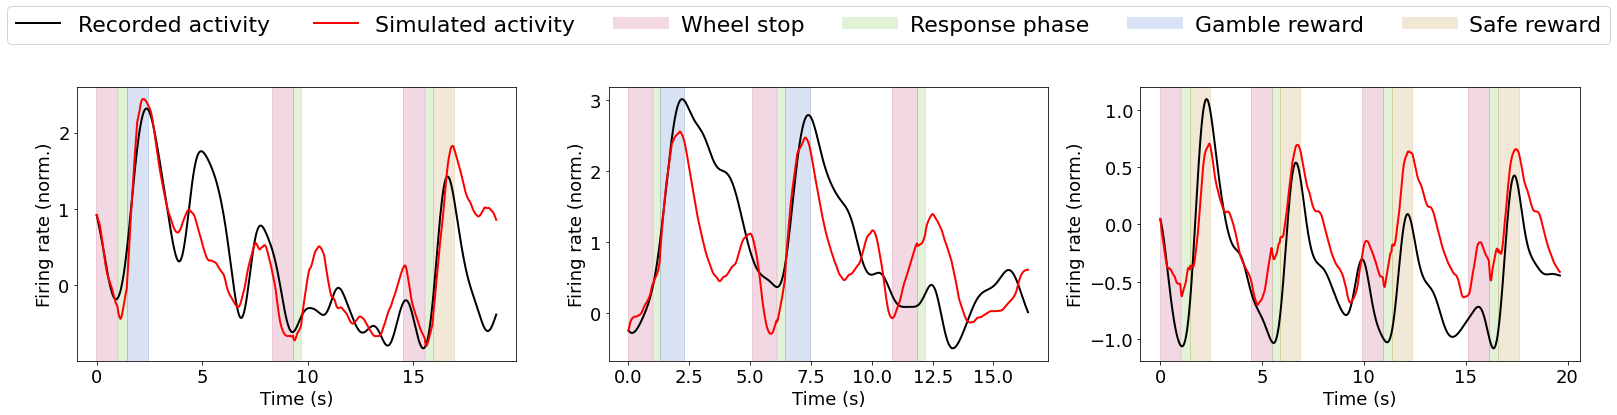

In [4]:
# %% Generation of Panel A

################################ Parameters to modify ################################ 
# Selection of data
eneu = 32                                                    # Selection of neuron
etrial = [2,15,45]                                              # Selection of specfic concatenated trial
# Plot properties
# colors
c_recorded_activity = 'black'                                   # Color for line: Recorded Activity 
c_simulated_activity = 'red'                                    # Color for line: Simulated Activity
c_stop = '#C13E71'                                              # Color for area: Wheel stop phase
c_cue = '#71C13E'                                               # Color for area: Response phase
c_gamble = '#3E71C1'                                            # Color for area: Gamble reward
c_safe = '#C18E3E'                                              # Color for area: Safe reward
alpha_value = 0.2                                               # Transparency level for sections of the trial (stop wheel, cue, reward g/s)
#####################################################################################

# Create subplots
plt.rcParams['font.size'] = 18
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
for ax,it in zip(axs,range(3)):
    # Creating x vector. (Time)
    vec_length = train_n[etrial[it]].shape[0]
    temp_vec = np.linspace(0,vec_length,vec_length)*0.02
    
    # Creating the areas for each trial
    #Wheel Stop
    #Sections Cue
    ini_stop = np.where(np.diff(train_i[etrial[it]][:,0])==1.)[0]-50
    end_stop = np.where(np.diff(train_i[etrial[it]][:,0])==1.)[0]
    stop_sections = [(ini_stop[i]*0.02,end_stop[i]*0.02) for i in range(len(ini_stop))]
    #Sections Cue
    ini_cue = np.where(np.diff(train_i[etrial[it]][:,0])==1.)[0]+1
    end_cue = np.where(np.diff(train_i[etrial[it]][:,0])==-1.)[0]+1
    cue_sections = [(ini_cue[i]*0.02,end_cue[i]*0.02) for i in range(len(ini_cue))]
    #Sections Reward Gamble
    ini_grew = np.where(np.diff(train_i[etrial[it]][:,1])==4.)[0]+1
    end_grew = np.where(np.diff(train_i[etrial[it]][:,1])==-4.)[0]+1+25
    grew_sections = [(ini_grew[i]*0.02,end_grew[i]*0.02) for i in range(len(ini_grew))]
    #Sections Reward Safe
    ini_srew = np.where(np.diff(train_i[etrial[it]][:,2])==1.)[0]+1
    end_srew = np.where(np.diff(train_i[etrial[it]][:,2])==-1.)[0]+1+25
    srew_sections = [(ini_srew[i]*0.02,end_srew[i]*0.02) for i in range(len(ini_srew))]

    # Ploting the data for each concatenated trial
    ax.plot(temp_vec,train_n[etrial[it]][:,eneu],color=c_recorded_activity, lw = 2,label="Recorded activity")
    ax.plot(temp_vec,ModelS[etrial[it]][:,eneu],color=c_simulated_activity, lw = 2,label="Simulated activity")
    for section in stop_sections:
        start, end = section
        ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_stop, alpha=alpha_value))
    for section in cue_sections:
        start, end = section
        ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_cue, alpha=alpha_value))
    for section in grew_sections:
        start, end = section
        ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_gamble, alpha=alpha_value))
    for section in srew_sections:
        start, end = section
        ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_safe, alpha=alpha_value))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Firing rate (norm.)")
# Add legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
rect_handles = [
    Line2D([0], [0], color=c_stop, alpha=alpha_value, lw=12, label='Stop'),
    Line2D([0], [0], color=c_cue, alpha=alpha_value, lw=12, label='Cue'),
    Line2D([0], [0], color=c_gamble, alpha=alpha_value, lw=12, label='Grew'),
    Line2D([0], [0], color=c_safe, alpha=alpha_value, lw=12, label='Srew')
]
fig.legend(handles=handles + rect_handles, labels=labels + ['Wheel stop','Response phase','Gamble reward','Safe reward'], 
           loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=6, fontsize = 22)
plt.tight_layout()

# Save Figure
fig.savefig("D:/_work_cestarellas/Analysis/Pack_Daniel_project/Figures/2_Figure/Trial_example_CE17.png")
plt.show()


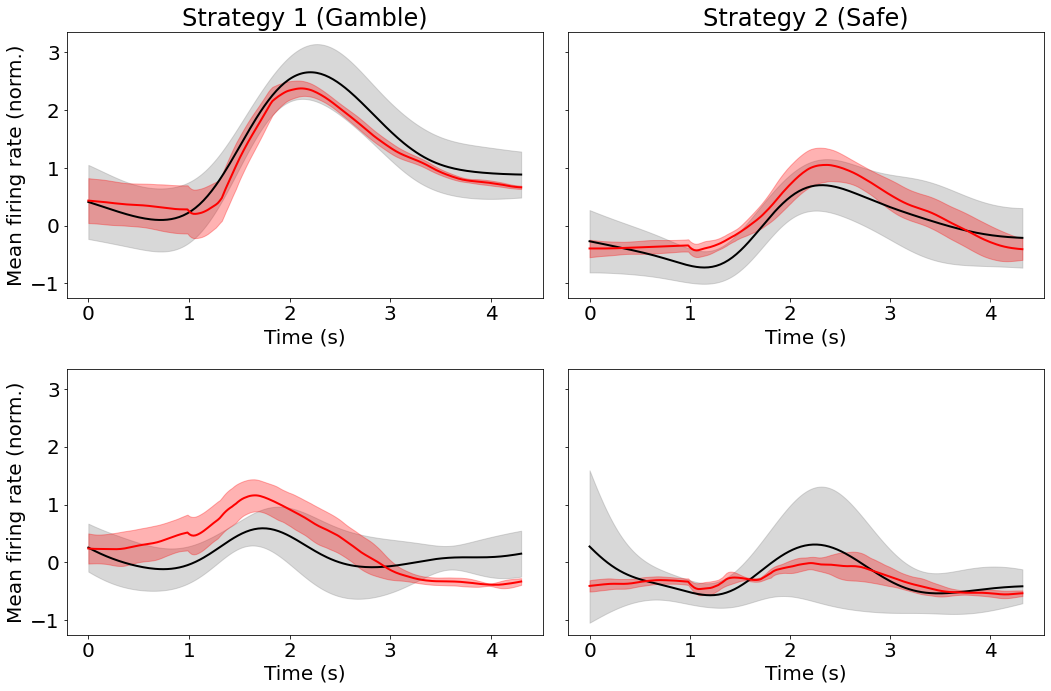

In [6]:
# %% Generation of Panel B (draft, the final plot could be complemented by a secondary software: illustrator, power point)

################################ Parameters to modify ################################ 
# Computation parameter
eneu=32                                                    # Neuron selected
#Strategy 1 (Gamble)
# W parameters are averaged across trials : from t_prev_s1 to t_post_s1
# t_prev_s1: Initial trial for averaging W parameters
# t_post_s1: Last trial for averaging W parameters
# # Session: CE17
t_prev_s1 = 11                                                   
t_post_s1 = 21
# Session: DM01_5
# t_prev_s1 = 38                                                   
# t_post_s1 = 48
# # Session: DM01_7
# t_prev_s1 = 80                                                   
# t_post_s1 = 90
# # Session: JG15_24
# t_prev_s1 = 5                                                   
# t_post_s1 = 10
# # Session: JG15_25
# t_prev_s1 = 7                                                   
# t_post_s1 = 18

#Strategy 2 (Safe)
# W parameters are averaged across trials : from t_prev_s2 to t_post_s2
# t_prev_s2: Initial trial for averaging W parameters
# t_post_s2: Last trial for averaging W parameters
# # Session: CE17
t_prev_s2 = 37                                                  
t_post_s2 = 47                                                  
# Session: DM01_5
#t_prev_s2 = 10                                                   
#t_post_s2 = 20
# # Session: DM01_7
# t_prev_s2 = 50                                                   
# t_post_s2 = 60
# # Session: JG15_24
# t_prev_s2 = 40                                                   
# t_post_s2 = 50
# # Session: JG15_25
# t_prev_s2 = 30                                                   
# t_post_s2 = 36

# Plot parameters
#####################################################################################

# Create Subplots
plt.rcParams['font.size'] = 20
alpha_value = 0.2
SGM_rew,SGN_rew,SGM_norew,SGN_norew = Avg_W_simulations(t_prev_s1,t_post_s1,eneu,train_n,train_i,1)
SSM_rew,SSN_rew,SSM_norew,SSN_norew = Avg_W_simulations(t_prev_s2,t_post_s2,eneu,train_n,train_i,0)


fig, axs = plt.subplots(2, 2, figsize=(15, 10),sharey=True)
#################################
# Strategy Gamble Reward
gml_mean = SGM_rew.mean(0) 
gme_max = gml_mean+SGM_rew.std(0)#/np.sqrt(SGM_rew.shape[0])
gme_min = gml_mean-SGM_rew.std(0)#/np.sqrt(SGM_rew.shape[0])

gnl_mean = SGN_rew.mean(0) 
gne_max = gnl_mean+SGN_rew.std(0)#/np.sqrt(SGM_rew.shape[0])
gne_min = gnl_mean-SGN_rew.std(0)#/np.sqrt(SGM_rew.shape[0])

time_vec = np.linspace(0,SGM_rew.shape[1],SGM_rew.shape[1])*0.02
axs[0,0].plot(time_vec,gnl_mean,color='black', lw= 2, label='Recorded Acvity')
axs[0,0].fill_between(time_vec, gne_max, gne_min, color='gray', alpha=0.3)
axs[0,0].plot(time_vec,gml_mean,color='red', lw = 2,label='Simulated Acvity')
axs[0,0].fill_between(time_vec, gme_max, gme_min, color='red', alpha=0.3)
axs[0,0].set_xlabel("Time (s)")
axs[0,0].set_ylabel("Mean firing rate (norm.)")
axs[0,0].set_title("Strategy 1 (Gamble)")
# Strategy Gamble No Reward
gmln_mean = SGM_norew.mean(0) 
gmen_max = gmln_mean+SGM_norew.std(0)#/np.sqrt(SGM_rew.shape[0])
gmen_min = gmln_mean-SGM_norew.std(0)#/np.sqrt(SGM_rew.shape[0])

gnln_mean = SGN_norew.mean(0) 
gnen_max = gnln_mean+SGN_norew.std(0)#/np.sqrt(SGM_rew.shape[0])
gnen_min = gnln_mean-SGN_norew.std(0)#/np.sqrt(SGM_rew.shape[0])

time_vec = np.linspace(0,SGM_norew.shape[1],SGM_norew.shape[1])*0.02
axs[1,0].plot(time_vec,gnln_mean,color='black', lw= 2, label='Recorded Acvity')
axs[1,0].fill_between(time_vec, gnen_max, gnen_min, color='gray', alpha=0.3)
axs[1,0].plot(time_vec,gmln_mean,color='red', lw = 2,label='Simulated Acvity')
axs[1,0].fill_between(time_vec, gmen_max, gmen_min, color='red', alpha=0.3)
axs[1,0].set_xlabel("Time (s)")
axs[1,0].set_ylabel("Mean firing rate (norm.)")

###############################
# Strategy Safe Reward
sml_mean = SSM_rew.mean(0) 
sme_max = sml_mean+SSM_rew.std(0)#/np.sqrt(SGM_rew.shape[0])
sme_min = sml_mean-SSM_rew.std(0)#/np.sqrt(SGM_rew.shape[0])

snl_mean = SSN_rew.mean(0) 
sne_max = snl_mean+SSN_rew.std(0)#/np.sqrt(SGM_rew.shape[0])
sne_min = snl_mean-SSN_rew.std(0)#/np.sqrt(SGM_rew.shape[0])

time_vec = np.linspace(0,SSM_rew.shape[1],SSM_rew.shape[1])*0.02
axs[0,1].plot(time_vec,snl_mean,color='black', lw= 2, label='Recorded Acvity')
axs[0,1].fill_between(time_vec, sne_max, sne_min, color='gray', alpha=0.3)
axs[0,1].plot(time_vec,sml_mean,color='red', lw = 2,label='Simulated Acvity')
axs[0,1].fill_between(time_vec, sme_max, sme_min, color='red', alpha=0.3)
axs[0,1].set_xlabel("Time (s)")
#axs[0,1].set_ylabel("Mean firing rate (std)")
axs[0,1].set_title("Strategy 2 (Safe)")

# Strategy Gamble No Reward
smln_mean = SSM_norew.mean(0) 
smen_max = smln_mean+SSM_norew.std(0)#/np.sqrt(SGM_rew.shape[0])
smen_min = smln_mean-SSM_norew.std(0)#/np.sqrt(SGM_rew.shape[0])

snln_mean = SSN_norew.mean(0) 
snen_max = snln_mean+SSN_norew.std(0)#/np.sqrt(SGM_rew.shape[0])
snen_min = snln_mean-SSN_norew.std(0)#/np.sqrt(SGM_rew.shape[0])

time_vec = np.linspace(0,SSM_norew.shape[1],SSM_norew.shape[1])*0.02
axs[1,1].plot(time_vec,snln_mean,color='black', lw= 2, label='Recorded Acvity')
axs[1,1].fill_between(time_vec, snen_max, snen_min, color='gray', alpha=0.3)
axs[1,1].plot(time_vec,smln_mean,color='red', lw = 2,label='Simulated Acvity')
axs[1,1].fill_between(time_vec, smen_max, smen_min, color='red', alpha=0.3)
axs[1,1].set_xlabel("Time (s)")
#axs[1,1].set_ylabel("Mean firing rate (std)")
plt.tight_layout()
#Save Figure
plt.savefig("D:/_work_cestarellas/Analysis/Pack_Daniel_project/Figures/2_Figure/W_average_CE17.pdf")
plt.show()

Chosen model is clipped shPLRNN, the bases Parameter has no effect here!
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


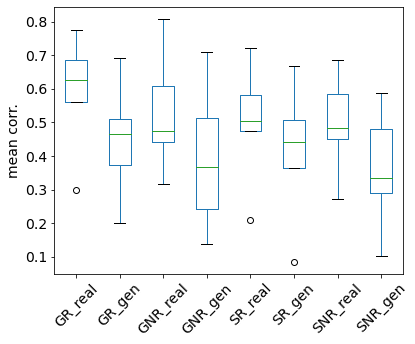

In [7]:
total_neu =  train_n[0].shape[1]
Corr_sectors = {}
mean_gr_n = [] ; mean_gr_m = []
mean_gnr_n = [] ; mean_gnr_m = []
mean_sr_n =[] ; mean_sr_m = []
mean_snr_n = [] ; mean_snr_m = []

#Strategy 1 (Gamble Choices)
# # Session: CE17,DM01_5,DM01_7,JG15_24,JG15_25
t_prev_s1 = [11,38,78,5,7]                                                   
t_post_s1 = [21,48,88,10,14]


#Strategy 2 (Safe Choices)
# # Session: CE17,DM01_5,DM01_7,JG15_24,JG15_25
t_prev_s2 = [37,10,50,37,28]                                                  
t_post_s2 = [47,20,60,47,34]                                                  

M_directory = "D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\"
model_folders=os.listdir(M_directory)

data_extra = "neuralactivity/datasets"
results_extra = "results/DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400/001"

#Variables initialization:
mean_gr_n = [] ; mean_gr_m = []
mean_gnr_n = [] ; mean_gnr_m = []
mean_sr_n = [] ; mean_sr_m = []
mean_snr_n = [] ; mean_snr_m = []
    
for itneu,name_model in enumerate(model_folders):
    ## Loading recorded neuronal activity (pre-processesed)
    Training_path=os.path.join(M_directory,name_model,data_extra).replace('\\','/')
    train_n,train_i = func.load_data(Training_path,'Training')
    test_n,test_i = func.load_data(Training_path,'Test')
    # Loading model
    PLRNN_path = os.path.join(M_directory,name_model,results_extra).replace('\\','/')
    num_epochs = 150000
    bttp_model = Model()
    bttp_model.init_from_model_path(PLRNN_path, epoch=num_epochs)
    bttp_model.eval()
    # Computing correlation for each neuron of the session
    CG_rr,CG_rg,CG_nrr,CG_nrg=Avg_W_sessions(t_prev_s1[itneu],t_post_s1[itneu],train_n,train_i,1,bttp_model)
    CS_rr,CS_rg,CS_nrr,CS_nrg=Avg_W_sessions(t_prev_s2[itneu],t_post_s2[itneu],train_n,train_i,0,bttp_model)
    # Collecting the mean correlation in each session
    mean_gr_n.append(np.array(CG_rr).mean())
    mean_gr_m.append(np.array(CG_rg).mean())
    mean_gnr_n.append(np.array(CG_nrr).mean())
    mean_gnr_m.append(np.array(CG_nrg).mean())
    mean_sr_n.append(np.array(CS_rr).mean())
    mean_sr_m.append(np.array(CS_rg).mean())
    mean_snr_n.append(np.array(CS_nrr).mean())
    mean_snr_m.append(np.array(CS_nrg).mean())

Corr_sectors["GR_real"]=mean_gr_n ; Corr_sectors["GR_gen"]=mean_gr_m
Corr_sectors["GNR_real"]=mean_gnr_n ; Corr_sectors["GNR_gen"]=mean_gnr_m
Corr_sectors["SR_real"]=mean_sr_n ; Corr_sectors["SR_gen"]=mean_sr_m
Corr_sectors["SNR_real"]=mean_snr_n ; Corr_sectors["SNR_gen"]=mean_snr_m

Corr_df = pd.DataFrame(Corr_sectors)
plt.rcParams['font.size'] = 14
plt.figure(figsize=(6,5))
Corr_df.boxplot(rot=45,grid=False)
plt.ylabel("mean corr.")
plt.tight_layout()
#Save Figure
plt.savefig("D:/_work_cestarellas/Analysis/Pack_Daniel_project/Figures/2_Figure/Correlation_WAveg.pdf")
plt.show()

In [ ]:
Training_path